In [1]:
import numpy as np
from scipy.stats import kstest, shapiro
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import lightgbm as lgb
from catboost import CatBoostRegressor
%matplotlib inline

In [2]:
data = pd.read_csv('clean1.csv', parse_dates=True)

In [3]:
data.head()

,Скважина,Дата,ГТМ,Метод,Характер работы,Состояние,"Время работы, ч",Время накопления,"Нефть, т","Попутный газ, м3",...,Ток рабочий,Тип ГЗУ,ДНС,КНС,Пластовое давление начальное,Характеристический дебит жидкости,Время в работе,Время в накоплении,ГП - Забойное давление,ГП(ИДН) Прирост дефита нефти
0,53514b4c4150ad897d82dd7d42cfc1a5,2012-03-30,0.0,ЭЦН/ФОН,НЕФ,РАБ.,301.0,0.0,278.55,10028.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53514b4c4150ad897d82dd7d42cfc1a5,2012-04-30,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,1074.74,38690.0,...,211.0,(),ДНС-1,КНС-1,231.0,847.308443,0.0,0.0,35.0,6.061904
2,53514b4c4150ad897d82dd7d42cfc1a5,2012-05-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,1046.80,37685.0,...,211.0,(),ДНС-1,КНС-1,231.0,590.462454,0.0,0.0,36.0,1.483960
3,53514b4c4150ad897d82dd7d42cfc1a5,2012-06-30,0.0,ЭЦН,НЕФ,РАБ.,744.0,0.0,900.95,32434.0,...,211.0,(),ДНС-1,КНС-1,231.0,644.968860,0.0,0.0,35.4,0.510737
4,53514b4c4150ad897d82dd7d42cfc1a5,2012-07-31,0.0,ЭЦН,НЕФ,РАБ.,720.0,0.0,761.72,27422.0,...,211.0,(),ДНС-1,КНС-1,231.0,583.248775,0.0,0.0,37.6,0.640583


**I. Градиентный бустинг на этих признаках как есть**

In [4]:
cat_features_indices = np.where(data.dtypes == 'object')[0]
cat_features_names = data.columns[cat_features_indices]
data.iloc[:, cat_features_indices] = data.iloc[:, cat_features_indices].fillna('Нет данных')

In [5]:
Y = data['Нефть, т']
X = data.drop(columns=['Нефть, т', 'Дата'])

In [6]:
cat_features_indices = np.where(X.dtypes == 'object')[0]

In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=6)

In [267]:
mdl = CatBoostRegressor(early_stopping_rounds=4)
mdl.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=True)

0:	learn: 821.3661099	test: 829.5233368	best: 829.5233368 (0)	total: 77ms	remaining: 1m 16s
1:	learn: 803.2167558	test: 810.9997111	best: 810.9997111 (1)	total: 107ms	remaining: 53.3s
2:	learn: 785.2245839	test: 792.2898329	best: 792.2898329 (2)	total: 183ms	remaining: 1m
3:	learn: 766.2775154	test: 772.6200086	best: 772.6200086 (3)	total: 220ms	remaining: 54.8s
4:	learn: 749.5202236	test: 755.3330552	best: 755.3330552 (4)	total: 282ms	remaining: 56.1s
5:	learn: 733.0446797	test: 738.4128247	best: 738.4128247 (5)	total: 355ms	remaining: 58.8s
6:	learn: 716.7372517	test: 721.6325972	best: 721.6325972 (6)	total: 402ms	remaining: 57s
7:	learn: 701.4144031	test: 705.7856481	best: 705.7856481 (7)	total: 483ms	remaining: 59.9s
8:	learn: 687.0433482	test: 690.9743406	best: 690.9743406 (8)	total: 522ms	remaining: 57.5s
9:	learn: 671.3946886	test: 674.7391535	best: 674.7391535 (9)	total: 576ms	remaining: 57s
10:	learn: 656.2421274	test: 659.1912717	best: 659.1912717 (10)	total: 635ms	remaining:

In [183]:
X.columns[mdl.feature_importances_ == 0]

Index(['Диаметр экспл.колонны', 'Тип насоса', 'Глубина спуска',
       'Время в накоплении'],
      dtype='object')

**II Добавим признаков из даты**

In [8]:
X['Год'] = pd.to_datetime(data['Дата']).map(lambda x: x.year)
X['Месяц'] = pd.to_datetime(data['Дата']).map(lambda x: x.month)

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=6)

In [270]:
mdl = CatBoostRegressor(early_stopping_rounds=4)
mdl.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=True)

0:	learn: 821.3283799	test: 829.5118535	best: 829.5118535 (0)	total: 34.8ms	remaining: 34.7s
1:	learn: 802.6494296	test: 810.5156731	best: 810.5156731 (1)	total: 109ms	remaining: 54.3s
2:	learn: 783.3598128	test: 790.3006111	best: 790.3006111 (2)	total: 151ms	remaining: 50.2s
3:	learn: 764.8383872	test: 771.4959077	best: 771.4959077 (3)	total: 210ms	remaining: 52.4s
4:	learn: 746.7923233	test: 753.2747441	best: 753.2747441 (4)	total: 289ms	remaining: 57.5s
5:	learn: 729.5533292	test: 735.2710128	best: 735.2710128 (5)	total: 338ms	remaining: 56s
6:	learn: 712.3454353	test: 717.5336842	best: 717.5336842 (6)	total: 404ms	remaining: 57.4s
7:	learn: 696.3905071	test: 700.9663593	best: 700.9663593 (7)	total: 481ms	remaining: 59.6s
8:	learn: 681.8740108	test: 685.9227813	best: 685.9227813 (8)	total: 559ms	remaining: 1m 1s
9:	learn: 666.4460430	test: 669.8677141	best: 669.8677141 (9)	total: 603ms	remaining: 59.6s
10:	learn: 652.8138079	test: 655.5744591	best: 655.5744591 (10)	total: 640ms	rema

In [201]:
X.columns[mdl.feature_importances_ < 0.01]

Index(['Приемистость, м3/сут', 'Куст', 'Диаметр штуцера', 'Тип насоса',
       'Глубина спуска', 'JD факт', 'Нерентабельная',
       'Замерное забойное давление', 'I X/X', 'Время в работе'],
      dtype='object')

**III. Заполним все признаки, имеющие нормальное распределение медианным значением (не сделано!!!)**

In [413]:
num_features = np.where(data.dtypes == 'float')
num_features

(array([ 2,  6,  7,  8,  9, 10, 11, 13, 14, 19, 20, 21, 22, 23, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61, 65, 67, 68, 69, 71,
        73, 74, 75, 76, 80, 81, 82, 83, 84, 85], dtype=int64),)

In [414]:
shapiro(data1.iloc[:, 83])

(nan, 1.0)

In [458]:
profile = ProfileReport(data)

In [459]:
profile.to_file('test2.html')

In [468]:
profile.get_rejected_variables()

['Давление в линии']

**IV. Заполнение константных признаков в зависимости от скважины**

In [453]:
gdf = data.groupby(by='Скважина', as_index=False).agg(np.mean)

In [92]:
gdf = data.groupby(by='Скважина', as_index=False).agg(np.var)

In [89]:
gdf

,Скважина,ГТМ,"Время работы, ч",Время накопления,"Нефть, т","Попутный газ, м3","Закачка, м3","Простой, ч","Приемистость, м3/сут","Обводненность (вес), %",...,Ток рабочий,Пластовое давление начальное,Характеристический дебит жидкости,Время в работе,Время в накоплении,ГП - Забойное давление,ГП(ИДН) Прирост дефита нефти,Идентификатор отсутствия добычи,Год,Месяц
0,005642f48d3e86d871bb701bac2ba042,0.166667,14899.200000,0.000000,1.953874e+05,8.003067e+08,0.0,2400.000000,0.000000,0.010667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,3.600000
1,02384c4d1324238fb99fcf66c88fbdad,0.000000,93789.866667,0.000000,1.136484e+05,7.878896e+08,0.0,0.000000,0.000000,282.760000,...,0.000000,0.000,6899.192796,0.0,0.0,0.229167,20.098567,0.166667,0.000000,4.400000
2,02bd0350b7f0cef7af7ca50801d89810,0.166667,82636.800000,0.000000,1.034629e+05,2.172088e+09,0.0,0.000000,0.000000,337.946667,...,5.735833,0.000,6229.803662,0.0,0.0,454.577676,15.508864,0.000000,0.166667,14.566667
3,02dba139f57f4aa50c3fbf56f586551f,0.266667,95097.600000,0.000000,3.614750e+04,1.480602e+08,0.0,0.000000,0.000000,60.590667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.266667,23.200000
4,038753062b1b3941bbce024a2af27e18,0.166667,43929.600000,0.000000,4.317406e+05,1.768409e+09,0.0,0.000000,0.000000,3.956000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.166667,14.566667
5,03d2a660f0b807a6a8cb3fc92575e13b,0.000000,84602.566667,0.000000,6.075887e+05,2.366786e+09,0.0,1.500000,0.000000,72.852000,...,2.722500,0.000,10240.786223,0.0,0.0,9.022186,593.623849,0.166667,0.000000,3.500000
6,04154a658a396d1c18331ebf0330744f,0.166667,71511.466667,0.000000,3.769067e+03,2.305120e+07,0.0,0.000000,0.000000,110.077667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,3.600000
7,046568c4bd1c6343c5f932ef6a21b112,0.166667,91161.600000,0.000000,1.750000e+03,7.560118e+06,0.0,0.000000,0.000000,1913.222667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266667,0.266667,23.200000
8,047a7a651d481e1c43b691c9e7dc07c9,0.000000,137673.766667,0.000000,1.490107e+04,6.101876e+07,0.0,0.166667,0.000000,10.286667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266667,0.000000,3.600000
9,04d7884a9f7019671285b87ca468d0f1,0.000000,29459.866667,0.000000,4.599522e+05,1.229296e+09,0.0,0.000000,0.000000,292.811000,...,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.300000,25.366667


In [10]:
# заполнение пропущенных значений по скважинам, если для скважины значение постоянное
for i in data['Скважина'].unique():
    for j in data.columns:
        if data[j].dtype == 'float' and np.nanvar(data.loc[data['Скважина']==i, j]) == 0:
            data.loc[data['Скважина']==i, j] = np.nanmean(data.loc[data['Скважина']==i, j])

c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  after removing the cwd from sys.path.


In [11]:
Y = data['Нефть, т']
X = data.drop(columns=['Нефть, т', 'Дата'])

In [12]:
X['Год'] = pd.to_datetime(data['Дата']).map(lambda x: x.year)
X['Месяц'] = pd.to_datetime(data['Дата']).map(lambda x: x.month)

In [462]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=6)

In [491]:
mdl3 = CatBoostRegressor(iterations=2000, learning_rate=4, loss_function='MAE', early_stopping_rounds=4)
mdl3.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=True)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 575.1424551	test: 595.9677657	best: 595.9677657 (0)	total: 23.4ms	remaining: 46.8s
1:	learn: 573.2007762	test: 594.0135800	best: 594.0135800 (1)	total: 95.5ms	remaining: 1m 35s
2:	learn: 571.7505439	test: 592.5394484	best: 592.5394484 (2)	total: 184ms	remaining: 2m 2s
3:	learn: 569.8944463	test: 590.6779912	best: 590.6779912 (3)	total: 265ms	remaining: 2m 12s
4:	learn: 568.3809299	test: 589.1230332	best: 589.1230332 (4)	total: 339ms	remaining: 2m 15s
5:	learn: 566.5811888	test: 587.3184732	best: 587.3184732 (5)	total: 414ms	remaining: 2m 17s
6:	learn: 565.0874912	test: 585.7682043	best: 585.7682043 (6)	total: 492ms	remaining: 2m 19s
7:	learn: 563.3133105	test: 583.9845732	best: 583.9845732 (7)	total: 573ms	remaining: 2m 22s
8:	learn: 561.7917190	test: 582.4173970	best: 582.4173970 (8)	total: 643ms	remaining: 2m 22s
9:	learn: 560.0421396	test: 580.6611250	best: 580.6611250 (9)	total: 739ms	remaining: 2m 27s
10:	learn: 558.5272487	test: 579.1191790	best: 579.1191790 (10)	total:

**Проанализируем объекты с нулевым значением добычи нефти**

In [ ]:
data['zeros'] = np.where(Y == 0, 1, 0)

In [23]:
data.columns

Index(['Скважина', 'Дата', 'ГТМ', 'Метод', 'Характер работы', 'Состояние',
       'Время работы, ч', 'Время накопления', 'Нефть, т', 'Попутный газ, м3',
       'Закачка, м3', 'Простой, ч', 'Причина простоя', 'Приемистость, м3/сут',
       'Обводненность (вес), %', 'Агент закачки', 'Пласт МЭР', 'Куст',
       'Тип скважины', 'Диаметр экспл.колонны', 'Диаметр НКТ',
       'Диаметр штуцера', 'Глубина верхних дыр перфорации', 'Удлинение',
       'Способ эксплуатации', 'Тип насоса', 'Производительность ЭЦН', 'Напор',
       'Частота', 'Глубина спуска', 'Буферное давление', 'Давление в линии',
       'Пластовое давление', 'Динамическая высота', 'Затрубное давление',
       'Давление на приеме', 'Забойное давление', 'Обводненность',
       'Состояние на конец месяца', 'Давление наcыщения', 'Газовый фактор',
       'Температура пласта', 'SKIN', 'JD факт', 'Дата ГРП',
       'Вязкость нефти в пластовых условиях', 'объемный коэффициент',
       'Плотность воды', 'Высота перфорации', 'Удельный ко

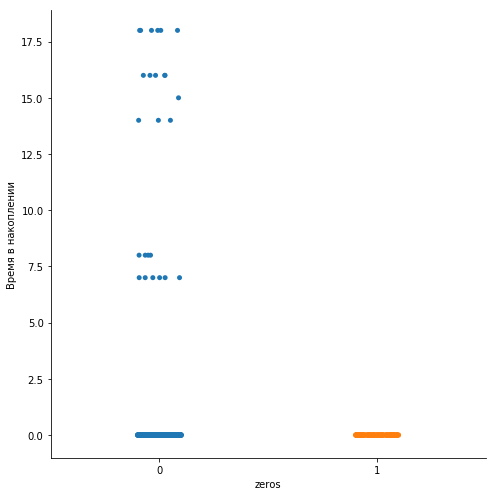

In [61]:
sns.catplot(x='zeros', y = 'Время в накоплении', data=data, height=7)

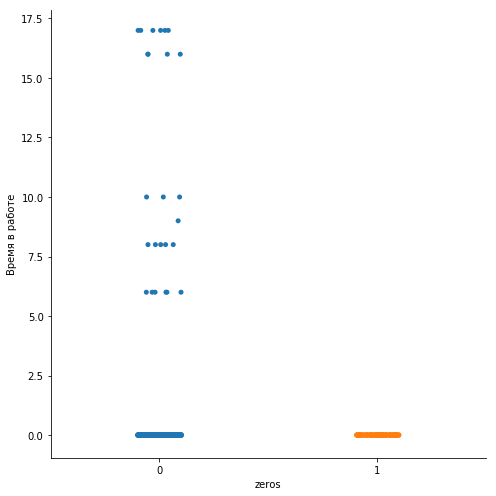

In [60]:
sns.catplot(x='zeros', y = 'Время в работе', data=data, height=7)

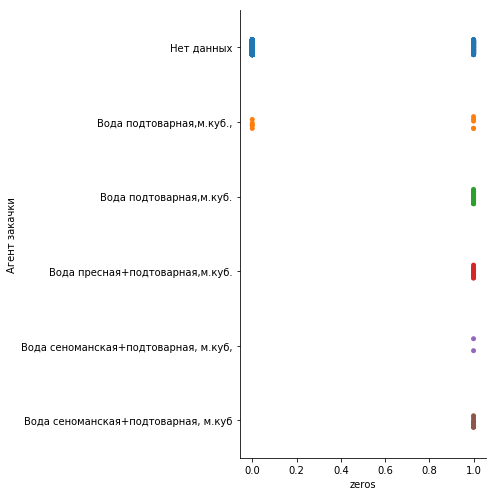

In [45]:
sns.catplot(x='zeros', y = 'Агент закачки', data=data, height=7)

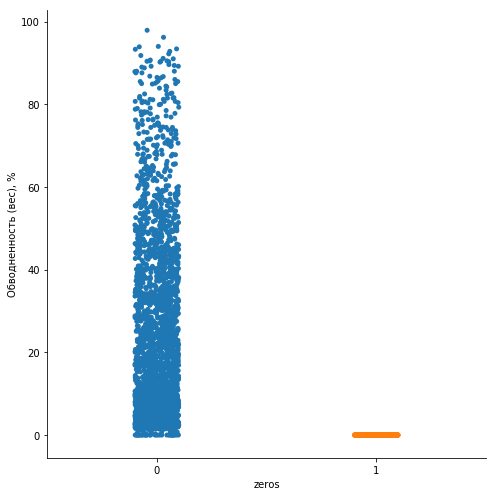

In [44]:
sns.catplot(x='zeros', y = 'Обводненность (вес), %', data=data, height=7)

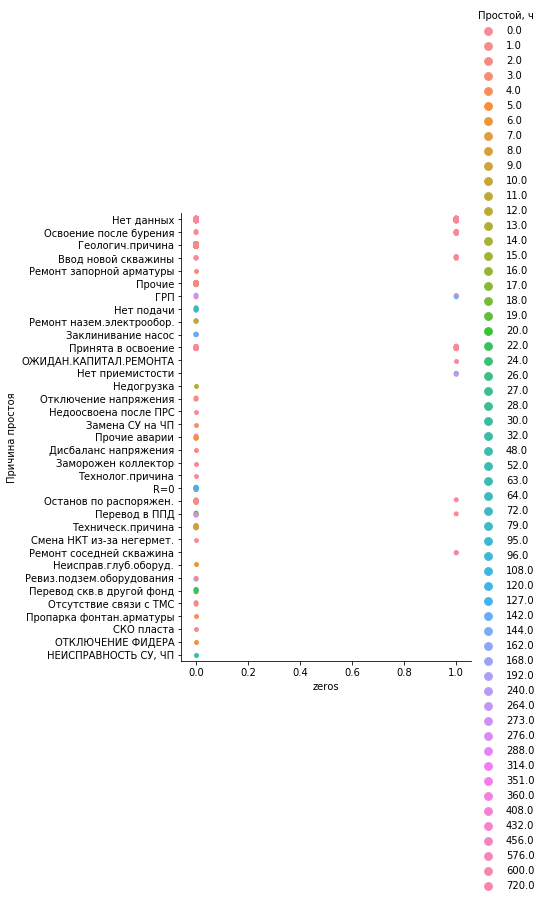

In [42]:
sns.catplot(x='zeros', y = 'Причина простоя', hue='Простой, ч', data=data, height=7)

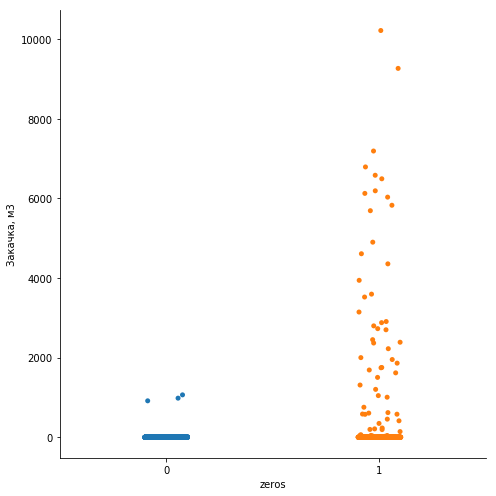

In [38]:
sns.catplot(x='zeros', y = 'Закачка, м3', data=data, height=7)

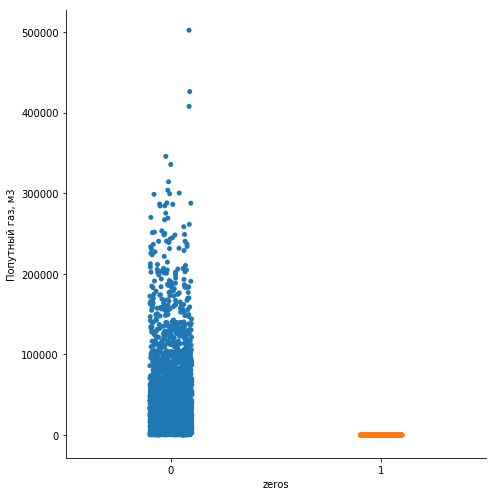

In [37]:
sns.catplot(x='zeros', y = 'Попутный газ, м3', data=data, height=7)

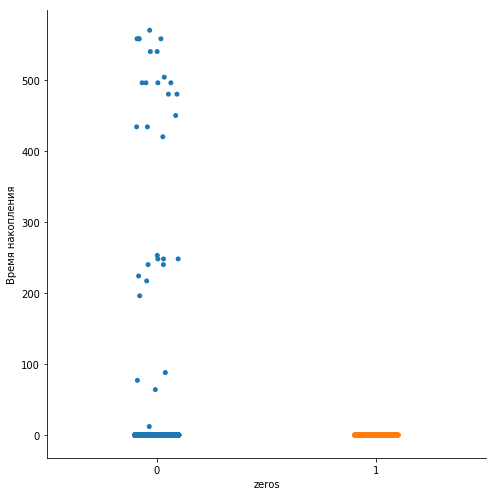

In [36]:
sns.catplot(x='zeros', y = 'Время накопления', data=data, height=7)

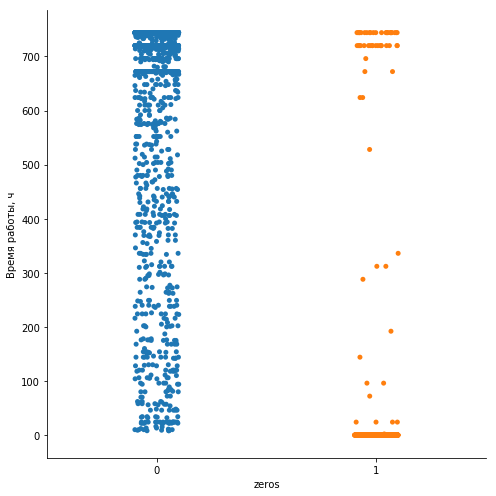

In [35]:
sns.catplot(x='zeros', y = 'Время работы, ч', data=data, height=7)

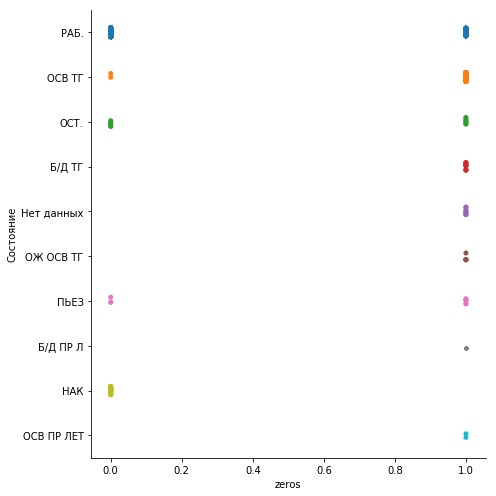

In [34]:
sns.catplot(x='zeros', y = 'Состояние', data=data, height=7)

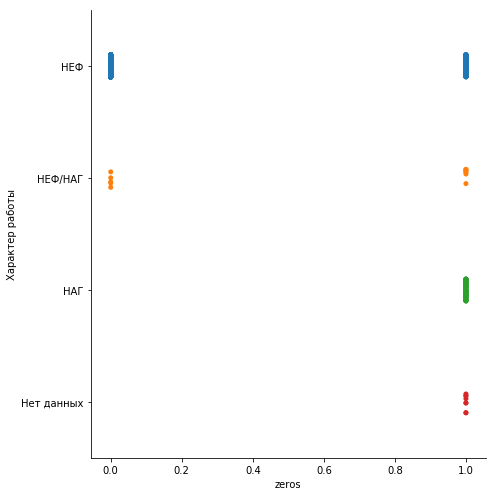

In [33]:
sns.catplot(x='zeros', y = 'Характер работы', data=data, height=7)

In [63]:
data['Идентификатор отсутствия добычи'] = np.where((data['Обводненность (вес), %'] == 0) & (data['Попутный газ, м3'] == 0), 1, 0)

In [65]:
data = data.drop(columns=['zeros'])

In [68]:
data['Год'] = pd.to_datetime(data['Дата']).map(lambda x: x.year)
data['Месяц'] = pd.to_datetime(data['Дата']).map(lambda x: x.month)

In [70]:
Y = data['Нефть, т']
X = data.drop(columns=['Нефть, т', 'Дата'])

In [71]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=6)

In [72]:
mdl3 = CatBoostRegressor(iterations=2000, learning_rate=4, loss_function='MAE', early_stopping_rounds=4)
mdl3.fit(X_train, Y_train, cat_features=cat_features_indices, eval_set=(X_valid, Y_valid), verbose=True)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 575.1550567	test: 595.9723500	best: 595.9723500 (0)	total: 180ms	remaining: 6m
1:	learn: 573.1948688	test: 594.0116973	best: 594.0116973 (1)	total: 268ms	remaining: 4m 27s
2:	learn: 571.7597909	test: 592.5529037	best: 592.5529037 (2)	total: 327ms	remaining: 3m 37s
3:	learn: 569.8683780	test: 590.6476370	best: 590.6476370 (3)	total: 369ms	remaining: 3m 4s
4:	learn: 568.3955385	test: 589.1401344	best: 589.1401344 (4)	total: 453ms	remaining: 3m
5:	learn: 566.5746615	test: 587.3000514	best: 587.3000514 (5)	total: 531ms	remaining: 2m 56s
6:	learn: 565.0904997	test: 585.7963828	best: 585.7963828 (6)	total: 608ms	remaining: 2m 53s
7:	learn: 563.2863713	test: 583.9494250	best: 583.9494250 (7)	total: 691ms	remaining: 2m 52s
8:	learn: 561.7938873	test: 582.4305129	best: 582.4305129 (8)	total: 771ms	remaining: 2m 50s
9:	learn: 560.0099632	test: 580.6311112	best: 580.6311112 (9)	total: 850ms	remaining: 2m 49s
10:	learn: 558.4994291	test: 579.0771614	best: 579.0771614 (10)	total: 935ms	re

In [80]:
preds = mdl3.get_test_eval()

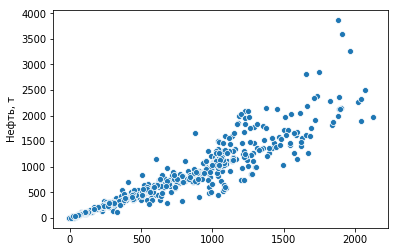

In [83]:
sns.scatterplot(preds, Y_valid)

In [95]:
import shap
from catboost import Pool

In [102]:
shap_values = mdl3.get_feature_importance(data=Pool(X_train, Y_train, cat_features=cat_features_indices), fstr_type='ShapValues')


TypeError: Cannot convert 'b'd55fa7c14dc2508fde23b0a4833b688e'' to float

In [100]:
X_train.shape

(2172, 87)

In [170]:
gridParams = {
    'learning_rate': [0.05, 0.1],
    'iterations': [300, 500, 700],
    'boosting_type' : ['Ordered', 'Plain'],
    'objective' : ['MAE'],
    'reg_lambda' : [0.6, 0.8, 1],
    'depth' : [3, 5, 7],
    'nan_mode' : ['Forbidden', 'Min', 'Max']
    }

In [171]:
grid = GridSearchCV(mdl, gridParams,
                    cv=4)

In [173]:
#grid.fit(X_train, Y_train, cat_features=cat_features_indices)

In [82]:
dummy_data = pd.get_dummies(data1, columns=cat_features_names)

In [83]:
dummy_data.head()

,ГТМ,"Время работы, ч",Время накопления,"Попутный газ, м3","Закачка, м3","Простой, ч","Приемистость, м3/сут","Обводненность (вес), %",Диаметр экспл.колонны,Диаметр НКТ,...,ДНС_ДНС-2,ДНС_ДНС-3,ДНС_ДНС-5,ДНС_ДНС-7,ДНС_Нет данных,КНС_КНС-1,КНС_КНС-2,КНС_КНС-3,КНС_КНС-5,КНС_Нет данных
0,0.0,301.0,0.0,10028.0,0.0,0.0,0.0,69.7,NaN,NaN,...,0,0,0,0,1,0,0,0,0,1
1,0.0,720.0,0.0,38690.0,0.0,0.0,0.0,38.2,146.8,67.4,...,0,0,0,0,0,1,0,0,0,0
2,0.0,744.0,0.0,37685.0,0.0,0.0,0.0,35.1,146.8,67.4,...,0,0,0,0,0,1,0,0,0,0
3,0.0,744.0,0.0,32434.0,0.0,0.0,0.0,32.1,146.8,67.4,...,0,0,0,0,0,1,0,0,0,0
4,0.0,720.0,0.0,27422.0,0.0,0.0,0.0,34.2,146.8,67.4,...,0,0,0,0,0,1,0,0,0,0


In [101]:
dummy_data.info()
cat_features_indices = np.where(dummy_data.dtypes == 'uint8')[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Columns: 855 entries, ГТМ to КНС_Нет данных
dtypes: float64(60), uint8(795)
memory usage: 3.5 MB


In [102]:
cat_features_indices

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 24

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(dummy_data, target, test_size=0.25, random_state=3)

In [86]:
params = {
    'task':'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

In [87]:
gbm = lgb.LGBMRegressor(**params)

In [88]:
grid = GridSearchCV(gbm, gridParams,
                    verbose=1,
                    cv=4)

In [103]:
gbm.fit(X_train, Y_train, eval_set=(X_test, Y_test), eval_metric='mae', early_stopping_rounds=5, categorical_feature=cat_features_indices)

c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1177: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categorical_feature == categorical_feature:
c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif categorical_feature == 'auto':
c:\users\aleksey\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 

TypeError: Wrong type(int64) or unknown name(60) in categorical_feature

In [74]:
#grid.fit(X_train, Y_train)

In [91]:
gbm.feature_importances_

NotFittedError: No booster found. Need to call fit beforehand.